## Final Project Submission

Please fill out:
* Student name: Abigail Campbell
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Morgan Jones
* Blog post URL:


# Setup

### Import relevant packages

In [1]:
import sqlite3 
import pandas as pd
import numpy as np
import zipfile
import scipy.stats as stats
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Load and Clean Data

### Gross Earnings

3356 entries after filtering

Assuming that any foreign-gross entries that are NaN were not released worldwide

In [5]:
# load data
gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz', thousands=',')

# remove all data points from gross that don't include domestic gross earnings or the studio name
gross = gross.dropna(axis=0, subset=['domestic_gross', 'studio'])

# fill Nan numbers in foreign_gross with 0 - assuming that the movie was not released foriegn
gross['foreign_gross'] = gross['foreign_gross'].fillna('0')

# convert foreign_gross column from object to float
gross['foreign_gross'] = pd.to_numeric(gross['foreign_gross'])

gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3356 non-null   object 
 1   studio          3356 non-null   object 
 2   domestic_gross  3356 non-null   float64
 3   foreign_gross   3356 non-null   float64
 4   year            3356 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 157.3+ KB


### Movie Info

1552 entries after filtering

Remove columns: currency, writer, runtime, synopsis, dvd_date

runtime note: value = integers, but each integer is followed by 'minutes'

dates note: given as month day, year format

    - month is in the three letter format
    - day is given as 1 or 2 digits (does not put a 0 in from on single digit days)
    - year is alwasy 4 digits
    
Genres given as a list in a single string

In [7]:
# load data
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', thousands=',')

# drop columns that are irrelevent
movie_info = movie_info.drop(['currency', 'writer', 'runtime', 'synopsis', 'dvd_date'], axis=1)

# remove NaN rows for genre
movie_info = movie_info.dropna(axis=0, subset=['genre'])

# separate genre into a list of genres
movie_info['genre'] = movie_info['genre'].map(lambda x: x.split('|'))

### Reviews

40915 entries after filtering

Review format = rating/total possible

Fresh = fresh and rotten are the only two values - will probably use this as the rating metric

Date: given as month day, year format
- month is in the three letter format
- day is given as 1 or 2 digits (does not put a 0 in from on single digit days)
- year is alwasy 4 digits

In [9]:
# load data
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='unicode_escape')

# convert fresh column to 0 (rotten) or 1 (fresh)
reviews['fresh_rating'] = reviews['fresh'].map(lambda x: 0 if 'rotten' in x else 1)

# remove all rows with no rating
reviews = reviews.dropna(axis=0, subset=['rating'])

reviews.info()
# reviews['fresh_rating'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40915 entries, 0 to 54431
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            40915 non-null  int64 
 1   review        35379 non-null  object
 2   rating        40915 non-null  object
 3   fresh         40915 non-null  object
 4   critic        38935 non-null  object
 5   top_critic    40915 non-null  int64 
 6   publisher     40688 non-null  object
 7   date          40915 non-null  object
 8   fresh_rating  40915 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 3.1+ MB


### Budgets

5792 entries after filtering

The budget and gross columns contain a dollar sign at the beginning of the value, as well as columns to separate out thousands.

    - remove dollar sign
    - remove commas
    - convert to integer

drop any entires with now movie title

In [10]:
# load data
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', thousands=',')

# format the money columns to be integers, without the $ sign
budgets = budgets.drop(['id'], axis=1)
budgets['production_budget'] = budgets['production_budget'].map(lambda x: int(x[1:].replace(',', '')))
budgets['domestic_gross'] = budgets['domestic_gross'].map(lambda x: int(x[1:].replace(',', '')))
budgets['worldwide_gross'] = budgets['worldwide_gross'].map(lambda x: int(x[1:].replace(',', ''))) 

# drop any moves with no title
budgets = budgets.dropna(subset=['movie'])

budgets = budgets.rename(columns={'movie': 'title'})
# budgets = budgets.set_index('title')

# calculate roi
budgets['domestic_roi'] = budgets['domestic_gross']/budgets['production_budget']
budgets['worldwide_roi'] = budgets['worldwide_gross']/budgets['production_budget']
len(budgets)

5782

### TMDB

looks clean - all columns have the same number of non-null entries.

columns that should be number-types are number-types

In [11]:
# Load data
tmdb = pd.read_csv('zippedData/tmdb.movies.csv.gz')

tmdb.info()
# tmdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


### SQL IMDB Database

In [12]:
# unzip imdb
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('zippedData')
    
# create connection to the SQL database
conn = sqlite3.connect('zippedData/im.db')

#### Movie Info

140,734 entries after filtering

    - filtered to only include moves released after 1980 (to only look at movies relevant to recent trends)
    - filtered out any entries with no movie title or genre
    
split the genre column up into a list of individual genres, rather than a string containing all

In [14]:
# table containing move title, id, start_year, and genres
# remove all lines without the genre

sql_movie_basics = pd.read_sql("""
                                SELECT movie_id, original_title, start_year, genres
                                    FROM movie_basics
                                """, conn)

# remove movies with no title
sql_movie_basics = sql_movie_basics.dropna(subset=['original_title'])

# remove movies before 1980 (trying to stay modern)
sql_movie_basics = sql_movie_basics[sql_movie_basics['start_year'] >= 1980]

# rename title column, drop all rows with no genre information
sql_movie_basics = sql_movie_basics.rename(columns={'original_title': 'title'})
sql_movie_basics = sql_movie_basics.dropna(axis=0, subset=['genres'])

# split the genres string into a list of individual genres
sql_movie_basics['genres'] = sql_movie_basics['genres'].map(lambda x: x.split(','))
sql_movie_basics['count'] = 1
sql_movie_basics.to_csv('data/sql_movie_basics.csv')
sql_movie_basics

,movie_id,title,start_year,genres,count
0,tt0063540,Sunghursh,2013,"[Action, Crime, Drama]",1
1,tt0066787,Ashad Ka Ek Din,2019,"[Biography, Drama]",1
2,tt0069049,The Other Side of the Wind,2018,[Drama],1
3,tt0069204,Sabse Bada Sukh,2018,"[Comedy, Drama]",1
4,tt0100275,La Telenovela Errante,2017,"[Comedy, Drama, Fantasy]",1
...,...,...,...,...,...
146138,tt9916428,The Secret of China,2019,"[Adventure, History, War]",1
146139,tt9916538,Kuambil Lagi Hatiku,2019,[Drama],1
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,[Documentary],1
146141,tt9916706,Dankyavar Danka,2013,[Comedy],1


#### Directors

69,772 entries after filtering

    - a movie with multiple directors will have multiple rows (one per director)

match movie titles to their director using the person and movie ids provided in the database

only include movies/directors with more than 10 votes in their rating to ensure that we are getting movies and directors with a wider reach

In [16]:
# import directors of movies with more than 10 reviews (to ensure we get movies with some reach)
director_table = pd.read_sql("""
    SELECT m.primary_title, p.primary_name, r.averagerating, r.numvotes
        FROM movie_basics as m
        JOIN directors as d
            ON m.movie_id = d.movie_id
        JOIN persons as p
            USING(person_id)
        JOIN movie_ratings as r
            USING(movie_id)
        WHERE numvotes > 10
    """, conn)
# drop any duplicate entires
director_table = director_table.drop_duplicates(keep='last')

# rename title column to just title - make all movie title columns univorm
director_table = director_table.rename(columns={'primary_title': 'title'})

director_table.to_csv('data/director_table.csv')
director_table

,title,primary_name,averagerating,numvotes
1,Laiye Je Yaarian,Sukh Sanghera,8.3,31
2,Borderless,Caolan Robertson,8.9,559
3,Borderless,George Llewelyn-John,8.9,559
4,Just Inès,Marcel Grant,6.4,20
8,The Legend of Hercules,Renny Harlin,4.2,50352
...,...,...,...,...
155471,Plugged in,Richard Willett,8.6,27
155472,Caisa,Alexandru Mavrodineanu,8.1,25
155474,Code Geass: Lelouch of the Rebellion - Glorifi...,Gorô Taniguchi,7.5,24
155475,Sisters,Prachya Pinkaew,4.7,14


# Combine tables to get the specific metrics

## Combine budgets table and movie info table

In [17]:
budgets_basics = budgets.merge(sql_movie_basics, left_on='title', right_on='title')

# add a realase month and release year column
budgets_basics['release_year'] = budgets_basics['release_date'].map(lambda x: int(x[-4:]))
budgets_basics['release_month'] = budgets_basics['release_date'].map(lambda x: x[0:4])

# only keep the movies that line up with their start year and release year (deal with duplicates)
# budgets_basics_2 = budgets_basics[(budgets_basics["release_year"] - budgets_basics["start_year"] <= 1) & (budgets_basics["release_year"] > budgets_basics["start_year"])].copy()
budgets_basics.to_csv('data/budgets_basics.csv')

# set title column name to just title - keep all title columns uniform
budgets_basics = budgets_basics.set_index('title')

# remove any duplicate titles - will be hard to combine with other tables when we are using the title as the point of comparison
budgets_basics = budgets_basics[~budgets_basics.index.duplicated()]


budgets_basics.loc[['Tangled']]
print(len(budgets_basics))

2253


### organize by genre

In [18]:
# separate out the genre column into one row for each individual genre
split_genres = budgets_basics.explode('genres')
split_genres.to_csv('data/split_genre.csv')

In [19]:
# get aggregations for genre information
genre_roi = split_genres.groupby('genres').mean()
genre_roi_sum = split_genres.groupby('genres').sum()
genre_roi['count'] = genre_roi_sum['count']
genre_roi['total_domestic_gross'] = genre_roi_sum['domestic_gross']
genre_roi['total_worldwide_gross'] = genre_roi_sum['worldwide_gross']

# recalc rois
genre_roi['domestic_roi'] = genre_roi['domestic_gross']/genre_roi['production_budget']
genre_roi['worldwide_roi'] = genre_roi['worldwide_gross']/genre_roi['production_budget']

genre_roi.to_csv('data/genre_roi.csv')
genre_roi.head()

,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,start_year,count,release_year,total_domestic_gross,total_worldwide_gross
genres,,,,,,,,,,
Action,6.967034e+07,7.385750e+07,2.020664e+08,1.060100,2.900322,2014.041121,535,2012.340187,39513760356,108105538143
Adventure,9.369193e+07,1.079033e+08,3.058193e+08,1.151682,3.264095,2014.341404,413,2013.130751,44564050081,126303387268
Animation,8.708843e+07,1.178347e+08,3.213194e+08,1.353046,3.689577,2014.278689,122,2012.573770,14375830513,39200969140
Biography,2.316298e+07,3.240609e+07,6.862025e+07,1.399047,2.962497,2014.254144,181,2011.817680,5865503054,12420266028
Comedy,3.515938e+07,4.968200e+07,1.125675e+08,1.413051,3.201633,2013.577223,641,2012.092044,31846159548,72155739621


## organize by release month

In [21]:
month_sums = budgets_basics.groupby('release_month').sum()
month_sums.to_csv('data/month_sums.csv')

month_means = budgets_basics.groupby('release_month').mean()
month_means.to_csv('data/month_means.csv')

month_sums

,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,start_year,count,release_year
release_month,,,,,,,,
Apr,5370090000,6392417315,15532343242,356.756961,600.289901,388648,193,387978
Aug,5147728000,6252729496,13052685537,399.081133,792.675482,364470,181,363760
Dec,8972178000,11473719031,27907952273,427.978351,784.435114,580001,288,578858
Feb,5350180000,6933198817,15197496383,262.175008,449.879525,312184,155,311800
Jan,3830791000,3959816615,9362905281,324.912913,602.752490,289976,144,289555
Jul,7682390000,9927438796,25833185062,546.607839,1046.653963,338262,168,337901
Jun,9243982311,13345603292,33047003585,329.219908,644.380602,350438,174,349800
Mar,7859414173,9010499990,21304885513,269.521657,474.133190,378617,188,378275
May,8293834785,9482982483,24682119442,310.804867,516.761825,304070,151,303636


## Combine directors table and budgets table

In [18]:
budgets_directors = budgets.merge(director_table, left_on='title', right_on='title')
budgets_directors = budgets_directors.set_index('title')
budgets_directors.to_csv('data/budgets_directors.csv')
budgets_directors

,release_date,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,primary_name,averagerating,numvotes
title,,,,,,,,,
Avatar,"Dec 18, 2009",425000000,760507625,2776345279,1.789430,6.532577,Atsushi Wada,6.1,43
Pirates of the Caribbean: On Stranger Tides,"May 20, 2011",410600000,241063875,1045663875,0.587101,2.546673,Rob Marshall,6.6,447624
Dark Phoenix,"Jun 7, 2019",350000000,42762350,149762350,0.122178,0.427892,Simon Kinberg,6.0,24451
Avengers: Age of Ultron,"May 1, 2015",330600000,459005868,1403013963,1.388403,4.243841,Joss Whedon,7.3,665594
Avengers: Infinity War,"Apr 27, 2018",300000000,678815482,2048134200,2.262718,6.827114,Anthony Russo,8.5,670926
...,...,...,...,...,...,...,...,...,...
Cure,"Jul 6, 2001",10000,94596,94596,9.459600,9.459600,Bill Yip,4.9,11
Newlyweds,"Jan 13, 2012",9000,4584,4584,0.509333,0.509333,Edward Burns,6.4,1436
Red 11,"Dec 31, 2018",7000,0,0,0.000000,0.000000,Robert Rodriguez,5.6,43


## Group by director and get average domestic and worldwide ROI

In [19]:
director_roi = budgets_directors.groupby('primary_name').mean()
director_roi_count = budgets_directors.groupby('primary_name').count()
director_row_sum = budgets_directors.groupby('primary_name').sum()

# combine tables
director_roi['count'] = director_roi_count['averagerating']
director_roi['total_production_budget'] = director_row_sum['production_budget']
director_roi['total_domestic_gross'] = director_row_sum['domestic_gross']
director_roi['total_worldwide_gross'] = director_row_sum['worldwide_gross']


# remove rows with 0 gross earnings for bother domestic and worldwide
director_roi = director_roi[(director_roi['domestic_gross'] >= 1000000) & (director_roi['worldwide_gross'] >= 1000000)]

director_roi.to_csv('data/director_roi.csv')
director_roi

,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,averagerating,numvotes,count,total_production_budget,total_domestic_gross,total_worldwide_gross
primary_name,,,,,,,,,,,
Aaron Seltzer,20000000.0,36661504.0,81424988.0,1.833075,4.071249,3.4,43984.0,1,20000000,36661504,81424988
Aash Aaron,3500000.0,12600000.0,12600000.0,3.600000,3.600000,8.1,16.0,1,3500000,12600000,12600000
Aashiq Abu,75000000.0,14010690.0,30626690.0,0.186809,0.408356,8.6,372.0,1,75000000,14010690,30626690
Abby Kohn,32000000.0,48795601.0,91553797.0,1.524863,2.861056,5.4,39936.0,1,32000000,48795601,91553797
Abhijit Guha,85000000.0,85900357.5,247044307.0,1.071387,3.007657,6.2,72.0,2,170000000,171800715,494088614
...,...,...,...,...,...,...,...,...,...,...,...
Zhigang Yang,70000000.0,55011732.0,94973540.0,0.785882,1.356765,7.1,581.0,1,70000000,55011732,94973540
Zhijian Tong,15000000.0,13843771.0,59168692.0,0.922918,3.944579,6.2,13.0,1,15000000,13843771,59168692
Zsófia Szilágyi,15000000.0,13843771.0,59168692.0,0.922918,3.944579,7.2,501.0,1,15000000,13843771,59168692


In [20]:
# sort top to bottom by domestic roi
director_roi_sorted = director_roi.sort_values('domestic_roi', ascending=False)
director_high_budgets = director_roi_sorted[(director_roi_sorted['production_budget'] >= 1000000)]
experienced_directors = director_high_budgets[(director_high_budgets['count'] > 2)]
experienced_directors
experienced_directors.to_csv('data/experienced_directors.csv')

In [21]:
experienced_directors_sorted = experienced_directors.sort_values('averagerating', ascending=False)
experienced_directors_sorted

,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,averagerating,numvotes,count,total_production_budget,total_domestic_gross,total_worldwide_gross
primary_name,,,,,,,,,,,
Christopher Nolan,1.875000e+08,2.797004e+08,7.715451e+08,1.466206,4.134089,8.425000,1.248687e+06,4,750000000,1118801468,3086180484
Dario Pleic,4.750000e+07,5.913765e+07,1.435970e+08,0.465154,30.851850,8.400000,3.200000e+01,3,142500000,177412943,430791064
Joe Russo,2.400000e+08,4.488823e+08,1.300869e+09,1.807660,5.196585,8.033333,6.402283e+05,3,720000000,1346646789,3902605502
Anthony Russo,2.400000e+08,4.488823e+08,1.300869e+09,1.807660,5.196585,8.033333,6.402283e+05,3,720000000,1346646789,3902605502
Denis Villeneuve,6.296000e+07,6.146980e+07,1.352639e+08,1.306876,2.672155,7.980000,3.741402e+05,5,314800000,307348989,676319696
...,...,...,...,...,...,...,...,...,...,...,...
Marcus Nispel,3.667500e+07,1.985304e+07,4.765334e+07,0.716605,8.083780,4.966667,6.227467e+04,3,110025000,59559106,142960010
Rob Cohen,2.633333e+07,2.267010e+07,3.993079e+07,3.298027,5.045590,4.966667,2.703100e+04,3,79000000,68010301,119792381
Dennis Dugan,7.800000e+07,1.232760e+08,2.232555e+08,1.589861,2.874250,4.900000,1.367460e+05,3,234000000,369827868,669766455


# Linear Regression

genres increasing in popularity

In [114]:
action = split_genres[split_genres['genres'] == 'Animation']
action_year = action.groupby('release_year', as_index=False).mean()
action_year_sum = action.groupby('release_year').sum()
action_year['count'] = action_year_sum['count']
action_year.head(10)

,release_year,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,start_year,count
0,1937,1.488000e+06,1.849255e+08,184925486.0,124.277880,124.277880,2017.0,NaN
1,1991,3.000000e+07,1.135022e+08,191502246.0,3.783408,6.383408,2019.0,NaN
2,1994,7.930000e+07,4.217853e+08,986214868.0,5.318856,12.436505,2019.0,NaN
3,1997,5.000000e+06,2.073348e+07,21277770.0,4.146697,4.255554,2016.0,NaN
4,1999,1.450000e+08,1.710918e+08,448191819.0,1.179944,3.090978,2013.0,NaN
5,2000,1.275000e+08,1.377481e+08,356148063.0,1.080377,2.793318,2011.0,NaN
6,2002,4.500000e+07,3.681811e+06,31681811.0,0.081818,0.704040,2021.0,NaN
7,2005,8.750000e+07,4.183996e+07,74409958.0,0.486933,0.872025,2017.0,NaN
8,2006,3.500000e+07,1.198933e+07,12506188.0,0.342552,0.357320,2015.0,NaN
9,2010,1.128182e+08,1.482025e+08,386324445.0,1.121897,3.148213,2010.0,NaN


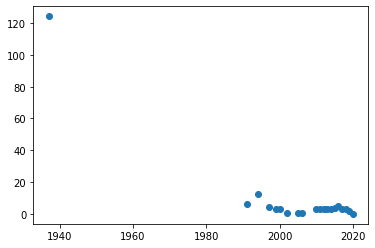

In [115]:
plt.scatter(action_year.release_year, action_year.worldwide_roi)

In [116]:
model = sm.OLS(endog=action_year.release_year, exog=sm.add_constant(action_year.worldwide_roi))

In [117]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           release_year   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     72.19
Date:                Fri, 25 Aug 2023   Prob (F-statistic):           1.03e-07
Time:                        11:59:40   Log-Likelihood:                -69.766
No. Observations:                  20   AIC:                             143.5
Df Residuals:                      18   BIC:                             145.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2010.4199      1.980   1015.145      0.000    2006.259    2014.581
worldwide_roi    -0.5989      0.070     -8.496      0.000      -0.747      -0.451
==============================================================================
Omnibus:                        3.918   Durbin-Watson:                   0.302
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                1.702
Skew:                          -0.355   Prob(JB):                        0.427
Kurtosis:                       1.760   Cond. No.                         29.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

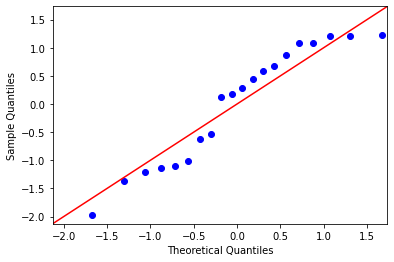

In [118]:
sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)
plt.show()

In [107]:
action_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_year       36 non-null     int64  
 1   production_budget  36 non-null     float64
 2   domestic_gross     36 non-null     float64
 3   worldwide_gross    36 non-null     float64
 4   domestic_roi       36 non-null     float64
 5   worldwide_roi      36 non-null     float64
 6   start_year         36 non-null     float64
 7   count              0 non-null      float64
dtypes: float64(7), int64(1)
memory usage: 2.5 KB


<AxesSubplot:xlabel='release_year', ylabel='worldwide_roi'>

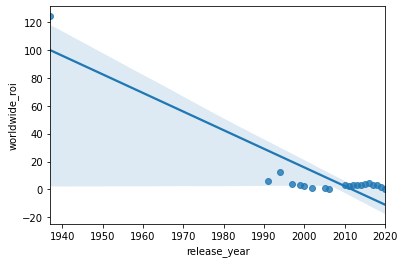

In [120]:
sns.regplot(x='release_year', y='worldwide_roi', data=action_year)